In [524]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from currency_converter import CurrencyConverter
import datetime
from forex_python.converter import CurrencyRates
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [525]:
df = pd.read_csv('https://drive.google.com/uc?export=download&id=130KYOX8O4wrP_T8vdz2GfvJRQ03ONmE7', index_col=0)

#### 1. Удаление дубликатов и стобцов, которые могут быть не важны для исследования.  
   
Парковка - пропущено 13417 из 23368 - 57,4%  
Название ЖК - пропущено 17520 из 23368 - 74,9%  
Серия дома - пропущено 21205 из 23368 - 90,7%  
Высота потолков, м  - пропущено 12162 из 23368 - 52%   
Мусоропровод - пропущено 10522 из 23368 - 45%  

Тип, Телефоны, Ссылка на объявление, площадь комнат, описание - параметры, не влияющие на стоимость

In [526]:
# Удаляем дубликаты по ID 
df = df.drop_duplicates(subset=['ID  объявления'], keep='first').reset_index(drop = True)

In [527]:
df = df.drop(['Парковка', 'Название ЖК', 'Серия дома', 'Высота потолков, м', 'Мусоропровод', 'Тип', 'Телефоны', 'Ссылка на объявление', 'Площадь комнат, м2', 'Описание'], axis = 1)

#### 2. Чистка данных  
  
* Работа с пропусками
* Фильтрация колонок
* Создание новых колонок
* Переименование колонок

In [528]:
# Кол-во комнат удаляем информацию про тип, оставляем только цифру, заполняем пропуски медианой
df['Количество комнат'] = df['Количество комнат'].apply(lambda x: int(x.split(', ')[0]) if isinstance(x, str) and ', ' in x else x)
df['Количество комнат']= df['Количество комнат'].fillna(df['Количество комнат'].median())
df.rename(columns={'Количество комнат': 'number_of_rooms'}, inplace=True)
df['number_of_rooms'] = df['number_of_rooms'].astype(int)


In [529]:
#Признак метро делим на два, Метро и время в пути
df.insert(loc=3, column='travel_time', value=[1] * len(df))
df['Метро'] = df['Метро'].fillna(df['Метро'].mode()[0])

# Обработка столбца 'Метро', деление на два столбца: 'metro' и 'travel_time'
def split_metro(row):
    if isinstance(row, str) and ' (' in row:
        return row.split(' (')[1].replace(')', '')
    else:
        return np.nan

df['travel_time'] = df['Метро'].apply(split_metro)
df['Метро'] = df['Метро'].apply(lambda row: row.split(' (')[0] if isinstance(row, str) and ' (' in row else row)
df.rename(columns={'Метро': 'metro'}, inplace=True)


In [530]:
# Пропусков в адресах нет, просто переименовываем и удаляем все строки, в которых указан другой город
df.rename(columns={'Адрес': 'address'}, inplace=True)
df = df[df['address'].str.contains("Москва")].reset_index(drop = True)

In [531]:
# Обрабатываем колонку с площадью, берём только общую площадь
df['Площадь, м2'] = [row.split('/')[0] for row in df['Площадь, м2']]
df.rename(columns={'Площадь, м2': 'square_m2'}, inplace=True)

In [532]:
# Разбиваем колонку дом
df['floor'] = [int(row.split('/')[0]) for row in df['Дом']]
df['floors'] = [int(row.split('/')[1].split(',')[0]) for row in df['Дом']]
df = df.drop(['Дом'], axis = 1)

In [533]:
# Из информации о цене достаем стоимость за месяц + депозит, и удаляем старый столбец
df['rent_price'] = [(row.split('/')[0]) for row in df['Цена']]
# df['deposit'] = [(row.split(' - ')[1].split(',')[0]) for row in df['Цена']]
df['deposit'] = [row.split(' - ')[1].split(',')[0] if 'Залог' in row else '0' for row in df['Цена']]

df = df.drop(['Цена'], axis = 1)

In [534]:
# Конвертация в рубли и приведение к интовому значению

import json
import requests
import re

url = ("https://iss.moex.com/iss/engines/currency/markets/selt/securities.jsonp?"
       "iss.only=securities,marketdata&"
       "securities=CETS:USD000UTSTOM,CETS:EUR_RUB__TOM&"
       "lang=ru&iss.meta=off&iss.json=extended&callback=angular.callbacks._gk")
data = requests.get(url)

# Обрежем лишнее (вызов функции и переводы строк)
text = data.text[22:len(data.text)-1:]
text = re.sub(r'\n', "", text)

json_string = json.loads(text)
list_price = []
for ss in json_string[1]['securities']:
    list_price.append(ss['PREVWAPRICE'])

# Задаем курсы валют на сегодняшний день (для примера)
usd_to_rub_rate = list_price[1]  # курс доллара к рублю
eur_to_rub_rate = list_price[0]  # курс евро к рублю

def convert_price_rent(text):
    if text != 0:
        parts = text.split(' ')
        amount = float(parts[0])  # получаем количество и преобразуем в float
        currency = parts[1]  # получаем тип валюты
        
        if currency == 'руб.':
            result = amount
        elif currency == '$':
            result = (amount * usd_to_rub_rate)
        elif currency == '€':
            result = (amount * eur_to_rub_rate)
        return int(result)
    else:
        return int(text)
    
def convert_price_dep(text):
    if text == '0':
        result = 0
        return int(result)
    elif ('€' in text):
        text = text.replace('€', "")
        result = float(text) * eur_to_rub_rate
        return int(result)

    if len(text.split(' ')) > 1:    
        parts = text.split(' ')
        amount = float(parts[0])  # получаем количество и преобразуем в float
        currency = parts[1]  # получаем тип валюты
        
        if currency == 'руб.':
            result = amount
        elif currency == '$':
            result = (amount * usd_to_rub_rate)
        return int(result)  
    else:
        return int(text)  
    

# Применяем функцию convert_price к столбцам 'rent_price' и 'deposit' в DataFrame
df['rent_price'] = df['rent_price'].apply(convert_price_rent)
df['deposit'] = df['deposit'].apply(convert_price_dep)

In [535]:
# Заполняем пропуски в столбце ремонт и переименовываем
df['Ремонт']= df['Ремонт'].fillna(df['Ремонт'].mode()[0])
df.rename(columns={'Ремонт': 'renovation_type'}, inplace=True)

In [536]:
# Обрабатываем колонку "балкон"
df['Балкон'] = df['Балкон'].fillna('Балкон (0), Лоджия (0)')
df['Лоджия'] = [row.split(' ')[-1] if (row.split(' ')[-2]) == 'Лоджия' else '(0)' for row in df['Балкон']]
df['Балкон'] = [row.split(' ')[1] if row.split(' ')[0] == 'Балкон' else '(0)' for row in df['Балкон']]

In [537]:
# Корректируем значения, избавляясь от скобок и переделывая из str в int
df['Лоджия'] = [row.split('(')[1] for row in df['Лоджия']]
df['Лоджия'] = [int(row.split(')')[0]) for row in df['Лоджия']]
df['Балкон'] = [row.split('(')[1] for row in df['Балкон']]
df['Балкон'] = [int(row.split(')')[0]) for row in df['Балкон']]

In [538]:
# Переименовываем балкон и лоджия
df.rename(columns={'Балкон': 'balcony'}, inplace=True)
df.rename(columns={'Лоджия': 'loggia'}, inplace=True)

In [539]:
# Заполняем пропуски в окнах и переименовываем
df['Окна'] = df['Окна'].fillna(df['Окна'].mode()[0])
df.rename(columns={'Окна': 'window'}, inplace=True)

In [540]:
# Столбец Санузел разбиваем на два
df['Санузел'] = df['Санузел'].fillna(df['Санузел'].mode()[0])
df['Санузел совмещенный'] = [row.split(' ')[1] if (row.split(' ')[0]) == 'Совмещенный' else '(0)' for row in df['Санузел']]
df['Санузел раздельный'] = [row.split(' ')[-1] if (row.split(' ')[-2]) == 'Раздельный' else '(0)' for row in df['Санузел']]
df['Санузел совмещенный'] = [row.split('(')[1] for row in df['Санузел совмещенный']]
df['Санузел совмещенный'] = [int(row.split(')')[0]) for row in df['Санузел совмещенный']]
df['Санузел раздельный'] = [row.split('(')[1] for row in df['Санузел раздельный']]
df['Санузел раздельный'] = [int(row.split(')')[0]) for row in df['Санузел раздельный']]
df = df.drop(['Санузел'], axis = 1)

In [541]:
# Переименовываем
df.rename(columns={'Санузел совмещенный': 'сombined_bath'}, inplace=True)
df.rename(columns={'Санузел раздельный': 'separate_bath'}, inplace=True)

In [542]:
# Заполняем пропуски в разделе можно с детьми/животными
df['Можно с детьми/животными'] = df['Можно с детьми/животными'].fillna(df['Можно с детьми/животными'].mode()[0])
df.rename(columns={'Можно с детьми/животными': 'child_pets_allow'}, inplace=True)

In [543]:
# Избавляемся от NaN, если меньше 5 этажей - нет лифта, в остальном по одному каждого лифта
df['Лифт'] = [row if row == row else
              ['Пасс (1), Груз (1)' if df['floors'].iloc[i]>5 else 'Пасс (0), Груз (0)'][0]
              for i, row in enumerate(df['Лифт'])]

In [544]:
# Разбиваем колонку с лифтами на две раздельные 
df['Лифт пасс'] = [row.split(' ')[1] if (row.split(' ')[0]) == 'Пасс' else '(0)' for row in df['Лифт']]
df['Лифт груз'] = [row.split(' ')[-1] if (row.split(' ')[-2]) == 'Груз' else '(0)' for row in df['Лифт']]

In [545]:
# Убираем скобки
df['Лифт пасс'] = [row.split('(')[1] for row in df['Лифт пасс']]
df['Лифт пасс'] = [int(row.split(')')[0]) for row in df['Лифт пасс']]
df['Лифт груз'] = [row.split('(')[1] for row in df['Лифт груз']]
df['Лифт груз'] = [int(row.split(')')[0]) for row in df['Лифт груз']]
df = df.drop(['Лифт'], axis = 1)

In [546]:
# Переименовываем
df.rename(columns={'Лифт пасс': 'passenger_lift'}, inplace=True)
df.rename(columns={'Лифт груз': 'cargo_lift'}, inplace=True)

In [547]:
# Заполняем пропуски в столбце дополнительно
df['Дополнительно'] = df['Дополнительно'].fillna(df['Дополнительно'].mode()[0])
df.rename(columns={'Дополнительно': 'additionally'}, inplace=True)

In [548]:
df.rename(columns={'ID  объявления': 'id'}, inplace=True)

In [549]:
df['metro'] = [row.split(' ')[1] for row in df['metro']]

In [550]:
metro_to_district = {
    'Авиамоторная': 'Восточный',
    'Автозаводская': 'Юго-Восточный',
    'Академическая': 'Юго-Западный',
    'Александровский сад': 'Центральный',
    'Алексеевская': 'Северный',
    'Алма-Атинская': 'Зеленоградский',
    'Алтуфьево': 'Северный',
    'Аминьевская': 'Западный',
    'Андроновка': 'Восточный',
    'Аннино': 'Южный',
    'Арбатская': 'Центральный',
    'Аэропорт': 'Северный',
    'Бабушкинская': 'Северо-Восточный',
    'Багратионовская': 'Западный',
    'Балтийская': 'Западный',
    'Баррикадная': 'Центральный',
    'Бауманская': 'Восточный',
    'Беговая': 'Северный',
    'Белокаменная': 'Восточный',
    'Беломорская': 'Северный',
    'Белорусская': 'Центральный',
    'Беляево': 'Юго-Западный',
    'Бескудниково': 'Северо-Западный',
    'Бибирево': 'Северо-Восточный',
    'Библиотека им. Ленина': 'Центральный',
    'Битца': 'Юго-Западный',
    'Битцевский парк': 'Юго-Западный',
    'Борисово': 'Юго-Восточный',
    'Боровицкая': 'Центральный',
    'Боровское шоссе': 'Юго-Западный',
    'Ботанический сад': 'Северо-Восточный',
    'Братиславская': 'Юго-Восточный',
    'Бульвар Адмирала Ушакова': 'Юго-Западный',
    'Бульвар Дмитрия Донского': 'Юго-Западный',
    'Бульвар Рокоссовского': 'Восточный',
    'Бунинская аллея': 'Юго-Западный',
    'Бутово': 'Юго-Западный',
    'Бутырская': 'Центральный',
    'Варшавская': 'Южный',
    'ВДНХ': 'Северо-Восточный',
    'Верхние котлы': 'Северный',
    'Верхние Лихоборы': 'Северо-Западный',
    'Владыкино': 'Северный',
    'Водный стадион': 'Северный',
    'Войковская': 'Северный',
    'Волгоградский проспект': 'Юго-Восточный',
    'Волжская': 'Юго-Восточный',
    'Волоколамская': 'Северо-Западный',
    'Воробьевы горы': 'Центральный',
    'Выставочная': 'Центральный',
    'Выставочный центр': 'Северо-Западный',
    'Выхино': 'Юго-Восточный',
    'Говорово': 'Северо-Западный',
    'Гражданская': 'Юго-Восточный',
    'Давыдково': 'Западный',
    'Дегунино': 'Северо-Западный',
    'Деловой центр': 'Центральный',
    'Депо': 'Северо-Восточный',
    'Динамо': 'Северный',
    'Дмитровская': 'Северный',
    'Добрынинская': 'Центральный',
    'Долгопрудная': 'Северный',
    'Домодедовская': 'Юго-Восточный',
    'Достоевская': 'Центральный',
    'Дубровка': 'Юго-Восточный',
    'Жулебино': 'Юго-Восточный',
    'ЗИЛ': 'Юго-Восточный',
    'Зорге': 'Северный',
    'Зюзино': 'Юго-Западный',
    'Зябликово': 'Юго-Восточный',
    'Измайлово': 'Восточный',
    'Измайловская': 'Восточный',
    'Каланчёвская': 'Центральный',
    'Калитники': 'Юго-Восточный',
    'Калужская': 'Юго-Западный',
    'Кантемировская': 'Юго-Восточный',
    'Каховская': 'Юго-Западный',
    'Каширская': 'Южный',
    'Киевская': 'Центральный',
    'Китай-город': 'Центральный',
    'Кожуховская': 'Юго-Восточный',
    'Коломенская': 'Юго-Восточный',
    'Комсомольская': 'Центральный',
    'Коньково': 'Юго-Западный',
    'Коптево': 'Северо-Западный',
    'Косино': 'Восточный',
    'Котельники': 'Юго-Восточный',
    'Красногвардейская': 'Юго-Восточный',
    'Краснопресненская': 'Центральный',
    'Красносельская': 'Центральный',
    'Красные ворота': 'Центральный',
    'Красный Балтиец': 'Юго-Западный',
    'Красный Строитель': 'Юго-Западный',
    'Крестьянская застава': 'Юго-Восточный',
    'Кропоткинская': 'Центральный',
    'Крылатское': 'Западный',
    'Крымская': 'Центральный',
    'Кубанская': 'Юго-Западный',
    'Кузнецкий мост': 'Центральный',
    'Кузьминки': 'Юго-Восточный',
    'Кунцевская': 'Западный',
    'Курская': 'Центральный',
    'Курьяново': 'Юго-Западный',
    'Кутузовская': 'Западный',
    'Ленинский проспект': 'Западный',
    'Лермонтовский проспект': 'Юго-Восточный',
    'Лесопарковая': 'Северо-Восточный',
    'Лефортово': 'Восточный',
    'Лианозово': 'Северо-Восточный',
    'Лихоборы': 'Северо-Западный',
    'Локомотив': 'Северо-Западный',
    'Ломоносовский проспект': 'Юго-Западный',
    'Лубянка': 'Центральный',
    'Лужники': 'Центральный',
    'Лухмановская': 'Восточный',
    'Люблино': 'Юго-Восточный',
    'Марк': 'Юго-Западный',
    'Марксистская': 'Юго-Восточный',
    'Марьина роща': 'Северо-Восточный',
    'Марьино': 'Юго-Восточный',
    'Маяковская': 'Центральный',
    'Медведково': 'Северо-Восточный',
    'Международная': 'Западный',
    'Менделеевская': 'Центральный',
    'Минская': 'Западный',
    'Митино': 'Северо-Западный',
    'Мичуринский проспект': 'Западный',
    'Мневники': 'Западный',
    'Молодежная': 'Западный',
    'Москва-Товарная': 'Центральный',
    'Москворечье': 'Южный',
    'Мякинино': 'Северо-Западный',
    'Нагатинская': 'Южный',
    'Нагорная': 'Южный',
    'Народное ополчение': 'Юго-Западный',
    'Нахабино': 'Северо-Западный',
    'Нахимовский проспект': 'Юго-Западный',
    'Некрасовка': 'Юго-Восточный',
    'Немчиновка': 'Западный',
    'Нижегородская': 'Юго-Восточный',
    'Новаторская': 'Юго-Восточный',
    'Новогиреево': 'Восточный',
    'Новодачная': 'Юго-Восточный',
    'Новокосино': 'Восточный',
    'Новокузнецкая': 'Центральный',
    'Новопеределкино': 'Западный',
    'Новослободская': 'Центральный',
    'Новохохловская': 'Юго-Западный',
    'Новоясеневская': 'Юго-Западный',
    'Новые Черемушки': 'Юго-Западный',
    'Озерная': 'Юго-Восточный',
    'Окружная': 'Юго-Восточный',
    'Окская': 'Северо-Западный',
    'Октябрьская': 'Центральный',
    'Октябрьское поле': 'Северо-Западный',
    'Орехово': 'Южный',
    'Отрадное': 'Северный',
    'Охотный ряд': 'Центральный',
    'Павелецкая': 'Центральный',
    'Павшино': 'Западный',
    'Панфиловская': 'Северо-Западный',
    'Парк Культуры': 'Центральный',
    'Парк Победы': 'Западный',
    'Партизанская': 'Восточный',
    'Пенягино': 'Северо-Западный',
    'Первомайская': 'Юго-Западный',
    'Перерва': 'Юго-Восточный',
    'Перово': 'Юго-Восточный',
    'Петровский Парк': 'Центральный',
    'Петровско-Разумовская': 'Северный',
    'Печатники': 'Юго-Восточный',
    'Пионерская': 'Северо-Западный',
    'Планерная': 'Северо-Западный',
    'Площадь Гагарина': 'Юго-Западный',
    'Площадь Ильича': 'Центральный',
    'Покровское': 'Северо-Восточный',
    'Покровское-Стрешнево': 'Северо-Западный',
    'Полежаевская': 'Северо-Западный',
    'Полянка': 'Центральный',
    'Пражская': 'Южный',
    'Преображенская площадь': 'Восточный',
    'Пролетарская': 'Юго-Восточный',
    'Проспект Вернадского': 'Западный',
    'Проспект Мира': 'Центральный',
    'Профсоюзная': 'Юго-Западный',
    'Пушкинская': 'Центральный',
    'Пятницкое шоссе': 'Северо-Западный',
    'Рабочий поселок': 'Юго-Восточный',
    'Раменки': 'Западный',
    'Рассказовка': 'Западный',
    'Речной вокзал': 'Северный',
    'Рижская': 'Северо-Восточный',
    'Римская': 'Центральный',
    'Ростокино': 'Северо-Восточный',
    'Румянцево': 'Западный',
    'Рязанский проспект': 'Юго-Восточный',
    'Савеловская': 'Северный',
    'Саларьево': 'Западный',
    'Свиблово': 'Северо-Восточный',
    'Севастопольская': 'Юго-Западный',
    'Селигерская': 'Северо-Западный',
    'Семеновская': 'Восточный',
    'Серпуховская': 'Центральный',
    'Сетунь': 'Западный',
    'Сколково': 'Западный',
    'Славянский бульвар': 'Юго-Восточный',
    'Смоленская': 'Центральный',
    'Сокол': 'Северный',
    'Соколиная гора': 'Северо-Восточный',
    'Сокольники': 'Восточный',
    'Солнцево': 'Западный',
    'Спартак': 'Северо-Западный',
    'Спортивная': 'Западный',
    'Сретенский бульвар': 'Центральный',
    'Стахановская': 'Северо-Западный',
    'Стрешнево': 'Северо-Западный',
    'Строгино': 'Северо-Западный',
    'Студенческая': 'Северо-Восточный',
    'Сухаревская': 'Центральный',
    'Сходненская': 'Северо-Западный',
    'Таганская': 'Центральный',
    'Тверская': 'Центральный',
    'Театральная': 'Центральный',
    'Текстильщики': 'Юго-Восточный',
    'Телецентр': 'Северный',
    'Теплый Стан': 'Юго-Западный',
    'Тестовская': 'Центральный',
    'Технопарк': 'Юго-Западный',
    'Тимирязевская': 'Северный',
    'Третьяковская': 'Центральный',
    'Трикотажная': 'Северо-Западный',
    'Тропарево': 'Юго-Западный',
    'Трубная': 'Центральный',
    'Тульская': 'Юго-Западный',
    'Тургеневская': 'Центральный',
    'Тушинская': 'Северо-Западный',
    'Угрешская': 'Юго-Восточный',
    'Улица 1905 года': 'Западный',
    'Улица Академика Королева': 'Северо-Восточный',
    'Улица Академика Янгеля': 'Западный',
    'Улица Горчакова': 'Юго-Западный',
    'Улица Дмитриевского': 'Юго-Восточный',
    'Улица Милашенкова': 'Юго-Западный',
    'улица Народного ополчения': 'Юго-Западный',
    'Улица Сергея Эйзенштейна': 'Северо-Западный',
    'Улица Скобелевская': 'Юго-Западный',
    'Улица Старокачаловская': 'Юго-Западный',
    'Университет': 'Юго-Западный',
    'Филевский парк': 'Западный',
    'Фили': 'Западный',
    'Фонвизинская': 'Северо-Восточный',
    'Фрунзенская': 'Юго-Западный',
    'Ховрино': 'Северо-Западный',
    'Хорошево': 'Северо-Западный',
    'Хорошевская': 'Северо-Западный',
    'Царицыно': 'Южный',
    'Цветной бульвар': 'Центральный',
    'ЦСКА': 'Северный',
    'Черкизовская': 'Северо-Восточный',
    'Чертановская': 'Юго-Западный',
    'Чеховская': 'Центральный',
    'Чистые пруды': 'Центральный',
    'Чкаловская': 'Центральный',
    'Шаболовская': 'Юго-Западный',
    'Шелепиха': 'Центральный',
    'Шипиловская': 'Юго-Восточный',
    'Шоссе Энтузиастов': 'Юго-Восточный',
    'Щелковская': 'Северо-Восточный',
    'Щербинка': 'Юго-Западный',
    'Щукинская': 'Северо-Западный',
    'Электрозаводская': 'Восточный',
    'Юго-Восточная': 'Юго-Восточный',
    'Юго-Западная': 'Юго-Западный',
    'Южная': 'Южный',
    'Ясенево': 'Юго-Западный',
    'Яхромская': 'Северо-Западный'
}

In [551]:
# Избавляемся от большого количества станций метро, меняем на регионы Москвы и с помощью Target Encoding кодируем
df['district'] = df['metro'].map(metro_to_district)
df = df.drop(['metro'], axis = 1)
district_means = df.groupby('district')['rent_price'].mean()
df['district'] = df['district'].map(district_means)
df['district'] = df['district'].fillna(df['district'].mean())
df['district'] = df['district'].round(2)

In [552]:
# Обрабатываем адрес, оставляя только название улицы и с помощью Target Encoding кодируем
df['address'] = [row.split(', ')[1].split(', ')[0] for row in df['address']]
mean_prices_by_address = df.groupby('address')['rent_price'].mean()
df['address'] = df['address'].map(mean_prices_by_address)
df['address'] = df['address'].round(2)

In [553]:
# Преобразуем значения в площади числовой формат с плавающей точкой
df['square_m2'] = df['square_m2'].astype(float)

# Затем преобразуем в целые числа
df['square_m2'] = df['square_m2'].astype(int)

In [554]:
# Обрабатываем renovation_type и кодируем помощью Target Encoding
mean_prices_by_renovation = df.groupby('renovation_type')['rent_price'].mean()
df['renovation_type'] = df['renovation_type'].map(mean_prices_by_renovation)
df['renovation_type'] = df['renovation_type'].round(2)

In [555]:
# Обрабатываем window и кодируем помощью Target Encoding
mean_prices_by_window = df.groupby('window')['rent_price'].mean()
df['window'] = df['window'].map(mean_prices_by_window)
df['window'] = df['window'].round(2)

In [556]:
# Обрабатываем child_pets_allow и кодируем помощью Target Encoding
mean_prices_by_child_pets_allow = df.groupby('child_pets_allow')['rent_price'].mean()
df['child_pets_allow'] = df['child_pets_allow'].map(mean_prices_by_child_pets_allow)
df['child_pets_allow'] = df['child_pets_allow'].round(2)

In [557]:
# Коэффициент пересчета времени авто во время пешком
coeff = 7
# Функция для извлечения числового значения и пересчета
def extract_travel_time(row):
    if 'None' in row:
        return None
    elif 'на машине' in row:
        return int(row.split(' ')[0]) * coeff
    elif 'пешком' in row:
        return int(row.split(' ')[0])
    return None
# Применяем функцию ко всем строкам колонки 'travel_time'
df['travel_by_feet'] = df['travel_time'].apply(extract_travel_time)
# Заменить None (или NaN) на среднее значение
df['travel_by_feet'] = df['travel_by_feet'].fillna(df['travel_by_feet'].mean())
df = df.drop(['travel_time'], axis=1)

In [558]:
df_dummies = df['additionally'].str.get_dummies(sep=', ')
df = pd.concat([df, df_dummies], axis=1)
df = df.drop(['additionally'], axis=1)

In [559]:
# Переименование новых столбоц
new_columns = {
    'Ванна': 'bath',
    'Душевая кабина': 'shower_cabin',
    'Интернет': 'internet',
    'Кондиционер': 'air_conditioner',
    'Мебель в комнатах': 'furniture_in_rooms',
    'Мебель на кухне': 'kitchen_furniture',
    'Посудомоечная машина': 'dishwasher',
    'Стиральная машина': 'washing_machine',
    'Телевизор': 'tv',
    'Телефон': 'telephone',
    'Холодильник': 'refrigerator'
}

df = df.rename(columns=new_columns)

In [560]:
# Удаляем выбросы в deposit
df = df[df['deposit'] < 5000000].reset_index(drop = True)

In [561]:
# Удаляем выбросы в pass_lift
df = df[df['passenger_lift'] < 49].reset_index(drop = True)

In [562]:
# Удаляем выбросы в travel_by_feet
df = df[df['travel_by_feet'] < 278].reset_index(drop = True)

In [563]:
df.to_csv('data_before_norm.csv')

In [564]:
# Создаем объект StandardScaler
scaler = StandardScaler()

# Выбираем все числовые признаки для нормировки (например, все столбцы, кроме целевой переменной)
numeric_features = ['number_of_rooms', 'square_m2', 'balcony', 'floor', 'floors', 'deposit', 'loggia','сombined_bath',
                     'separate_bath','passenger_lift', 'cargo_lift', 'travel_by_feet']



# Нормируем данные
df[numeric_features] = scaler.fit_transform(df[numeric_features])
df[numeric_features] = df[numeric_features].round(2)

<Axes: >

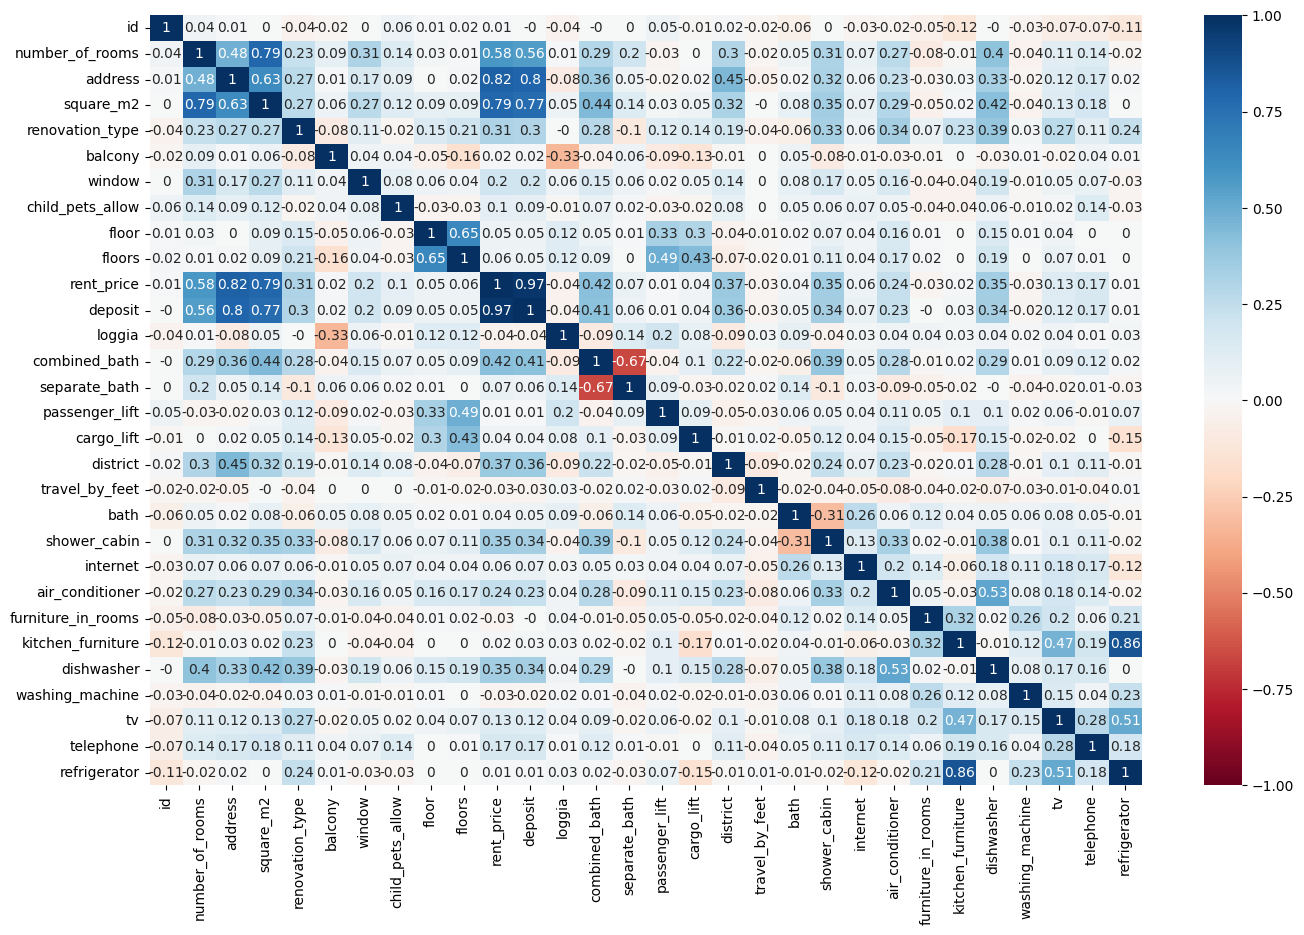

In [565]:
# Строим корреляционную матрицу по числовым фичам 
corr_matrix = df.corr().round(2)
figl, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(corr_matrix, annot=True, cmap="RdBu", vmax=1, vmin=-1)

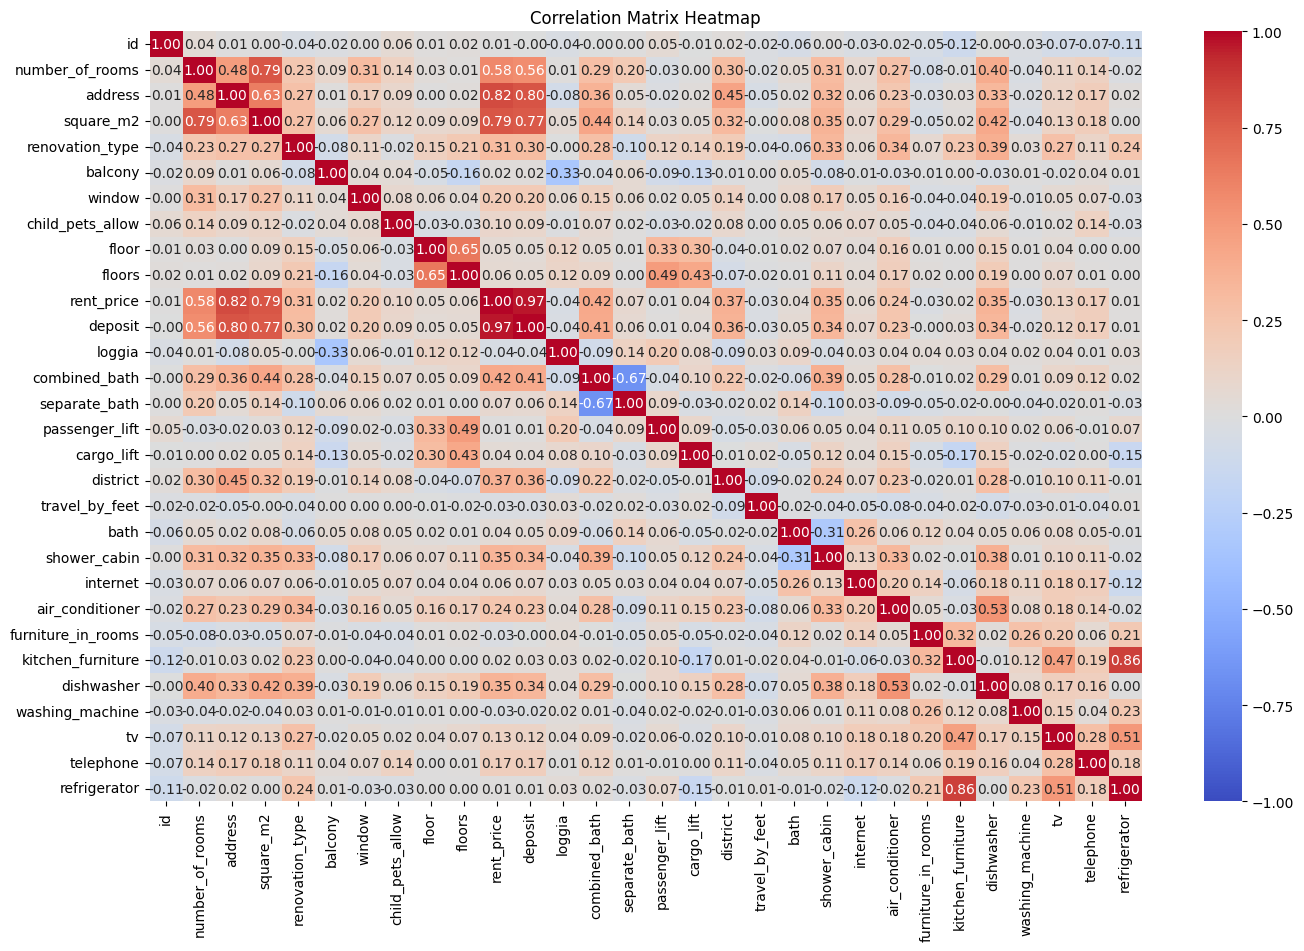

In [576]:
corr_matrix = df.corr()

# Создаем тепловую карту корреляционной матрицы
plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

Признаки с коэффициентом корреляции более 0.5:
['number_of_rooms', 'address', 'square_m2', 'deposit']


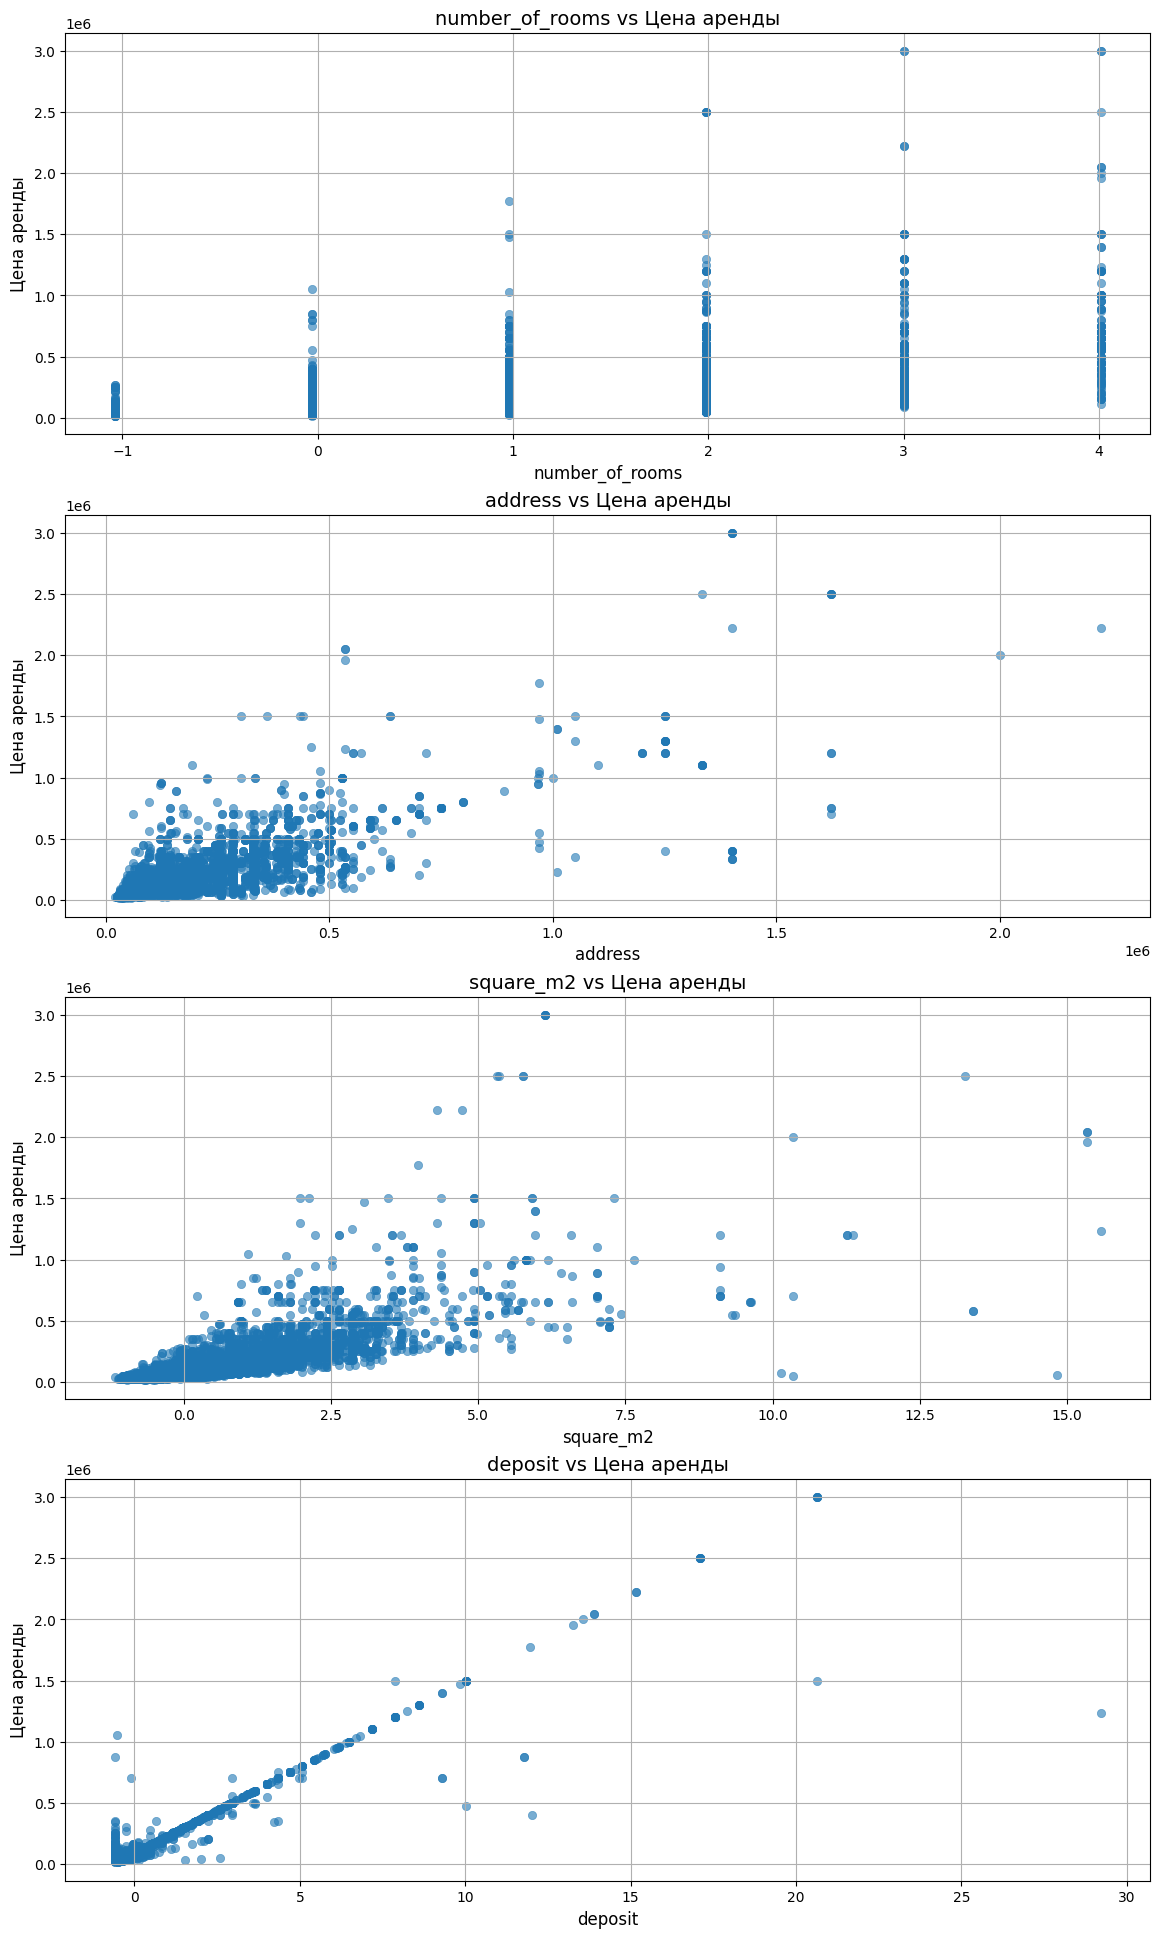

In [584]:
# Выберем признаки с коэффициентом Пирсона более 0.5
threshold = 0.5
strong_corr_features = corr_matrix.index[abs(corr_matrix['rent_price']) > threshold].tolist()

# Удалим саму цену из списка
strong_corr_features.remove('rent_price')

print("Признаки с коэффициентом корреляции более 0.5:")
print(strong_corr_features)

# Построим точечные распределения для этих признаков
plt.figure(figsize=(14, 6 * len(strong_corr_features)))

for i, feature in enumerate(strong_corr_features, 1):
    plt.subplot(len(strong_corr_features), 1, i)
    sns.scatterplot(data=df, x=feature, y='rent_price', alpha=0.6, edgecolor=None)
    plt.title(f'{feature} vs Цена аренды', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Цена аренды', fontsize=12)
    plt.grid(True)

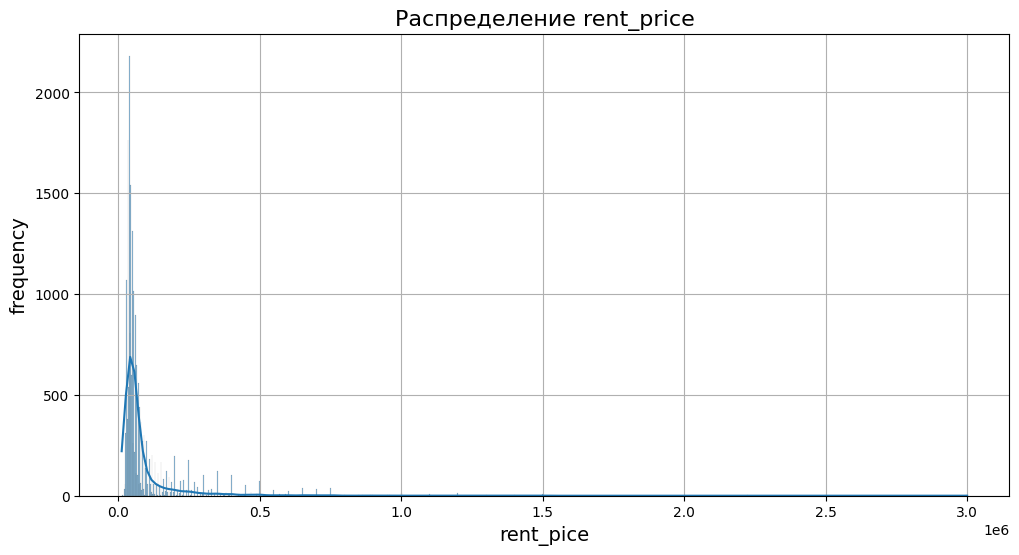

In [581]:
plt.figure(figsize=(12, 6))
sns.histplot(df['rent_price'], kde=True)
plt.title('Распределение rent_price', fontsize=16)
plt.xlabel('rent_pice', fontsize=14)
plt.ylabel('frequency', fontsize=14)
plt.grid(True)
plt.show()

In [566]:
df.to_csv('data.csv')